# Numerical exercise 01


In [32]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import curve_fit
from scipy.stats import norm, cauchy, chi2
import scipy.stats as stats

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']


## Exercise 01.1

#### Assignment
- Test the Pseudo-Random Number generator downloaded from the NSL Ariel web site by estimating:

1. $\langle r \rangle = \int_0^1 r dr = 1/2$. Make a picture of the estimation of $\langle r \rangle$ and its uncertainty (which corresponds to Standard Deviation of the mean for the estimation of $\langle r \rangle$) with a large number of *throws* $M$ (e.g. $M\ge 10^4$) as a function of the number of blocks, $N$ (see below: Computing statistical uncertainties).
2. $\sigma^2 = \int_0^1 (r-1/2)^2 dr = 1/12$. Make a picture of the estimation of $\sigma^2$ and its uncertainty (which corresponds to Standard Deviation of the mean for the estimation of $\langle (r-1/2)^2 \rangle$) with a large number of *throws* $M$ (e.g. $M\ge 10^4$) as a function of the number of blocks, $N$ (see below: Computing statistical uncertainties).
3. Divide $[0,1]$ into $M$ identical sub-intervals and implement the $\chi^2$ test. Obviously, the number of expected events observed in each sub-interval after $n$ *throws*, according to a uniform distribution, is $np = n\times 1/M= n/M$. Fix $M=10^2$ and use for $n$ the first $10^4$ pseudo-random numbers, then the successive $10^4$ pseudo-random numbers, and so on ... 100 times. Plot $\chi^2_j$ for $j=1, ..., 100$. In this case the chi-square statistic is:
$$\chi^2 = \sum_{i=1}^M \frac{\left( n_i - n/M \right)^2}{n/M}$$
We should expect on average that $(n_i - n/M)^2 \simeq n/M$ and thus $\chi^2 \simeq 100$, i.e. the number of sub-intervals.
A larger value of $\chi^2$ indicates that the hypothesis ($n_i$ are drawn from a uniform distribution) is rather unlikely ... but before judging, you could compare the histogram of the values obtained for $\chi^2_j$ with the true probability distribution (see: <a href="https://en.wikipedia.org/wiki/Chi-squared_distribution">this Wikipedia link</a>).

### Resolution
To veify the goodness of the provided random number generator, we can compute the average value of the generated numbers. We expect from a uniform distribution spanning over $[0,1)$ an average value of $\langle r \rangle = \int_0^1 r dr = 1/2$.

To compute the average value we leverage the blocking method: given $M$ random numbers, we divide them into $N$ blocks of size $L = M/N$. For each block we accumulate a sum of the values, and then we average over the block size.
This method gives us the possibility to extimate the uncertainty of the average value, by using the standard deviation of the mean value.
The statistical uncertainity up to the $n$-th block is given by:
$$
\sigma_{\langle r \rangle} = \sqrt{\frac{1}{n} \left( \langle r^2 \rangle - \langle r \rangle^2 \right)}
$$
where
$$
\langle r^2 \rangle \simeq \frac{1}{n} \sum_{i=1}^n r^2_i \quad \quad \langle r\rangle^2 \simeq \left( \frac{1}{n} \sum_{i=1}^n r_i \right)^2
$$
We expect the uncertainty to decrease as $\sqrt{N}$.

#### Code
The logic of the blocking average is hidden in the [```BlockingAvg```](../exercise_01/library01.h). The method ```Calculate(int n_throws, int n_blocks, Random &rnd, ofstream &file)``` takes care of setting the loops for the blocking method and writing the results to the output file.
If it were to be explicit, it would look as:
```cpp
void BlockingAvg::Calculate(int n_throws, int n_blocks, Random &rnd, ofstream &file){
    //reset cumulative avg
    cum_avg = 0.;
    cum_avg2 = 0.;
    // set lenght of each block
    l_block = (double)n_throws/(double)n_blocks;
    for(int i{0}; i<n_blocks; i++){
        //reset current sum
        sum = 0;
        fmt::print(cerr, "Running block # {0}/{1}\r", i+1, n_blocks);
        for (int i=0; i<l_block; i++){
            sum += rnd.Rannyu(); // how we accumulate this sum changes depending on the request
        }
        cum_avg += sum/(double)l_block;
        cum_avg2 += pow(sum/(double)l_block, 2);
        //write out to file
        fmt::print(file, "{0}\t{1}\t{2}\n", (i+1), cum_avg/(double)(i+1), Error(cum_avg/(double)(i+1), cum_avg2/(double)(i+1), i));
    }
    std::fflush(stdout);
}


double BlockingAvg::Error(double ave, double av2, int i){
    if(i == 0){
        return 0.;
    }
    else{
        return sqrt(fabs(av2 - ave*ave)/((double)i));
    }
}

```
The method ```Calculate``` is defined then as:
```cpp
void BlockingAvg::Calculate(int n_throws, int n_blocks, Random &rnd, ofstream &file){
    //reset cumulative avg
    cum_avg = 0.;
    cum_avg2 = 0.;
    // set lenght of each block
    l_block = (double)n_throws/(double)n_blocks;
    for(int i{0}; i<n_blocks; i++){
        //reset current sum
        sum = 0;
        fmt::print(cerr, "Running block # {0}/{1}\r", i+1, n_blocks);
        Average(rnd);
        //write out to file
        fmt::print(file, "{0}\t{1}\t{2}\n", (i+1), cum_avg/(double)(i+1), Error(cum_avg/(double)(i+1), cum_avg2/(double)(i+1), i));
    }
    std::fflush(stdout);
}
```
with the method ```Average``` that cointains the cycle for each block, and the method that defines how we increment ```sum``` defined as ```Funny(Random &rnd)```. This last two methods are overriddeble in the derived classes such as ```BlockingVar``` used in the seccond point of the exercise:
```cpp
void BlockingVar::Funny(Random &rnd){
    sum += pow(rnd.Rannyu() - 0.5, 2);
}
```

Values chosen for the data blocking are $M = 10^6$ and $N = 100$.

For $\chi^2$ computation, we divide the interval $[0,1]$ into $M = 100$ sub-intervals. We then extract $1e4$ random numbers and count how many of them fall into each sub-interval. We then compute the $\chi^2$ value for this set of numbers, repeating this process $100$ times. The $\chi^2$ value is computed as per the assignment.


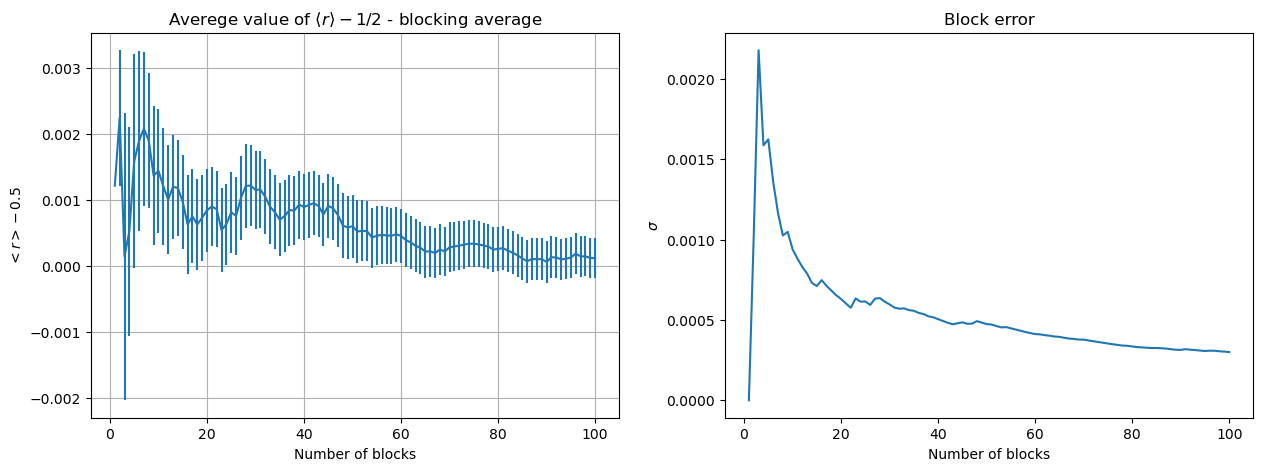

In [33]:
n_throws, cum_avg, block_error = np.loadtxt("../data/ex01_1a.dat", unpack=True, usecols=(0,1,2))

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.errorbar(n_throws, cum_avg-0.5, yerr=block_error)
plt.title(r"Averege value of $\langle r \rangle - 1/2$ - blocking average")
plt.xlabel('Number of blocks')
plt.ylabel(r"$<r>-0.5$")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(n_throws, block_error)

plt.title("Block error")
plt.xlabel('Number of blocks')
plt.ylabel(r"$\sigma$")

plt.show()

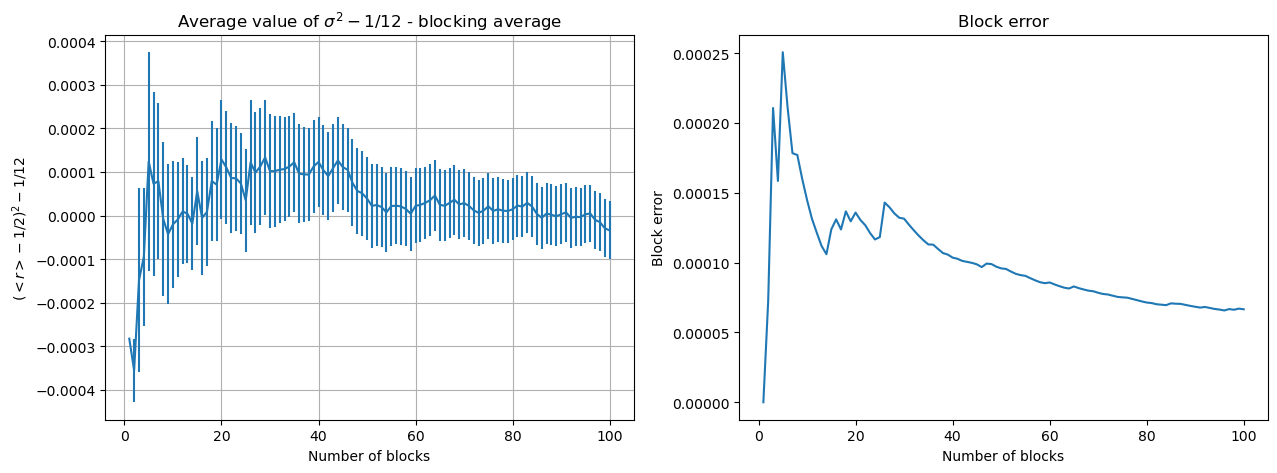

In [34]:
vn_throws, vcum_avg, vblock_error = np.loadtxt("../data/ex01_1b.dat", unpack=True, usecols=(0,1,2))

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.errorbar(vn_throws, vcum_avg-1/12, yerr=vblock_error)
plt.title(r"Average value of $\sigma^2 - 1/12$ - blocking average")
plt.xlabel('Number of blocks')
plt.ylabel(r"$(<r>-1/2)^2 - 1/12$")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(vn_throws, vblock_error)
plt.title("Block error")

plt.xlabel('Number of blocks')
plt.ylabel('Block error')

plt.show()



#### $\chi^2$ test
We can implement a $\chi^2$ test to verify that the extracted random numbers are indeed random incoming from an uniform distribution.
The code extracts $M = 10^4$ numbers and counts how many of them falls in each of the $M = 100$ sub-intervals of $[0,1]$.
We can the plot the $\chi^2$ value for each of the $100$ extractions, and realizes an histogram of the values.
Looking at the plotted values, we can see that the points are distributed around the expected value of $100$.

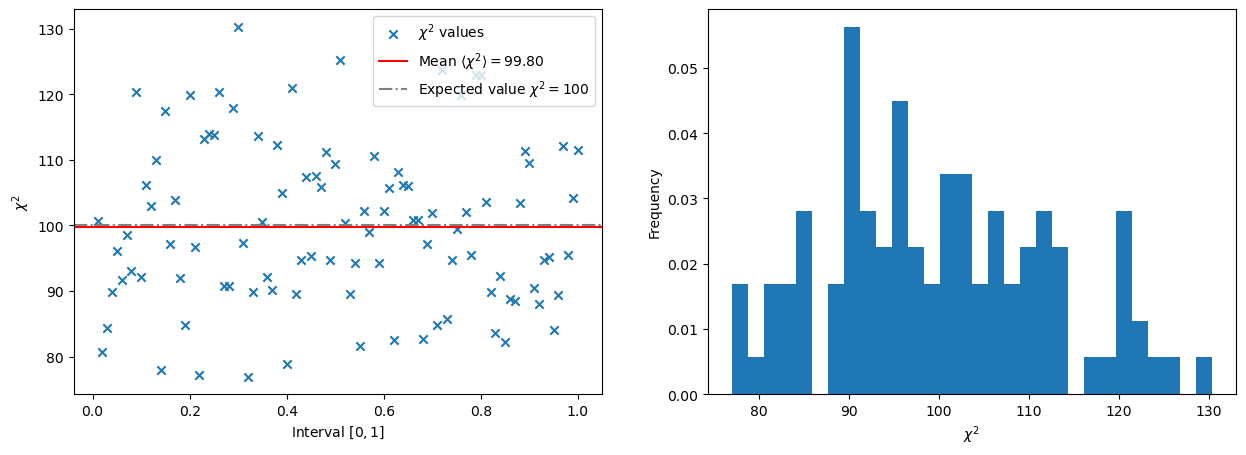

Mean = 99.80, std = 12.36


In [35]:
point, chi2 = np.loadtxt("../data/ex01_1c.dat", unpack=True, usecols=(0,1))

plt.figure(figsize=(15,5))

mean = chi2.mean()
std = chi2.std()

plt.subplot(1,2,1)
plt.scatter(point*(1/100), chi2, marker="x", label=r"$\chi^2$ values")
plt.axhline(y=mean, color='r', linestyle='-', label=r"Mean $\langle \chi^2 \rangle = {avg:.2f}$".format(avg=mean))
plt.axhline(y=100, color='gray', linestyle='-.', label=r"Expected value $\chi^2=100$")
plt.xlabel(r"Interval $[0,1]$")
plt.ylabel(r"$\chi^2$")
plt.legend()

plt.subplot(1,2,2)
plt.hist(chi2, 30, density=True)
plt.xlabel(r"$\chi^2$")
plt.ylabel("Frequency")
plt.show()

print("Mean = {0:.2f}, std = {1:.2f}".format(chi2.mean(), chi2.std()))


## Exercise 01.2

#### Assignment
- Extend Pseudo-Random Number generator downloaded from the NSL Ariel web site and check the Central Limit Theorem:
1. Add two probability distributions by using the **method of the inversion of the cumulative distribution** to sample from a **generic** exponential distribution, $p(x) = \lambda \exp(-\lambda x)$, $x\in [0;+\infty]$ (see <a href="https://en.wikipedia.org/wiki/Exponential_distribution">this Wikipedia link</a>), and a **generic** Cauchy-Lorentz distribution $p(x)=\frac{1}{\pi}\frac{\Gamma}{(x-\mu)^2+\Gamma^2}$, $x\in [-\infty;+\infty]$ (see <a href="https://en.wikipedia.org/wiki/Cauchy_distribution">this Wikipedia link</a>).
2. Make 3 pictures with the histograms obtained filling them with $10^4$ realizations of $S_N = \frac{1}{N}\sum_{i=1}^N x_i$ (for $N=1, 2, 10, 100$), being $x_i$ a random variable sampled throwing a *standard* dice (fig.1), an *exponential* dice (fig.2, use $\lambda=1$) and a *Lorentzian* dice (fig.3, use $\mu=0$ and $\Gamma=1$).

Note tha you can try to fit the case $N=100$ with a Gaussian for standard and exponential dices, whereas you should use a Cauchy-Lorentz distribution for the last case.

### Resolution
We already have a method to sample from an uniform distribution. For the other distributions we can use the method of the inversion of the cumulative distribution.
The cumulative distribution (CDF) is the integral of the probability distribution function (PDF) from $-\infty$ to $x$:
$$F_{x}(x) = \int_{-\infty}^{x} p(x) dx$$
Once we have the CDF, we can invert it to get the PDF:
$$x = F_{x}^{-1}(F_{x})$$
Where $F_{x}$ can be sampled from an uniform distribution in the interval $[0,1]$.

#### Exponential distribution
$$p(x) = \lambda \exp(-\lambda x)$$
The cumulative distribution is:
$$
F_{x}(x) = 1 - \exp(-\lambda x)
$$
The inverse of the cumulative distribution is:
$$
x = -\frac{1}{\lambda} \log(1 - F_{x}(x))
$$

#### Cauchy-Lorentz distribution
$$p(x)=\frac{1}{\pi}\frac{\Gamma}{(x-\mu)^2+\Gamma^2}$$
The cumulative distribution is:
$$
F_{x}(x) = \frac{1}{\pi} \arctan\left( \frac{x-\mu}{\Gamma} \right) + \frac{1}{2}
$$
The inverse of the cumulative distribution is:
$$
x = \mu + \Gamma \tan\left( \pi \left( F_{x}(x) - \frac{1}{2} \right) \right)
$$

We can now sample the sums of $N$ random variables from the three distributions, and for the case $N=100$ we can fit the results with a Gaussian for the first two cases and with a Cauchy-Lorentz distribution for the last case: this way we can verify the concept of the basin of attraction.

For distribution with finite variance, the Central Limit Theorem states that the sum of $N$ random variables tends to a Gaussian distribution for $N \to \infty$.
For distribution with infinite variance, the Central Limit Theorem states that the sum of $N$ random variables tends to a Cauchy-Lorentz distribution for $N \to \infty$.


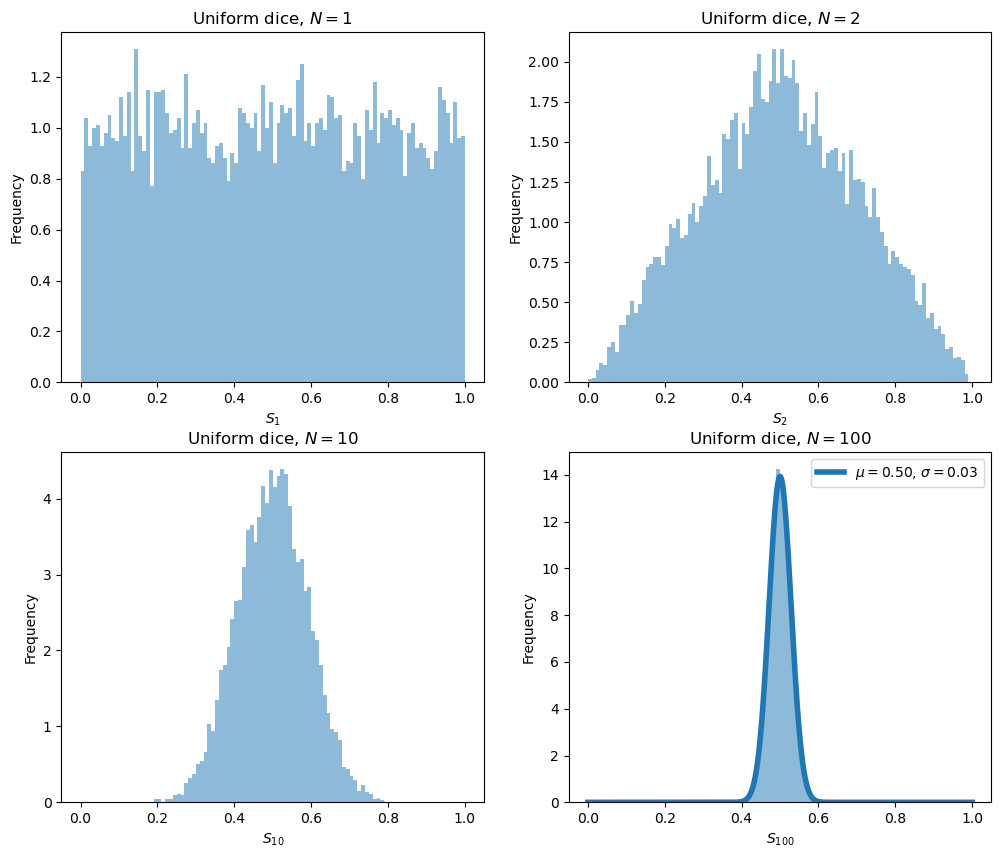

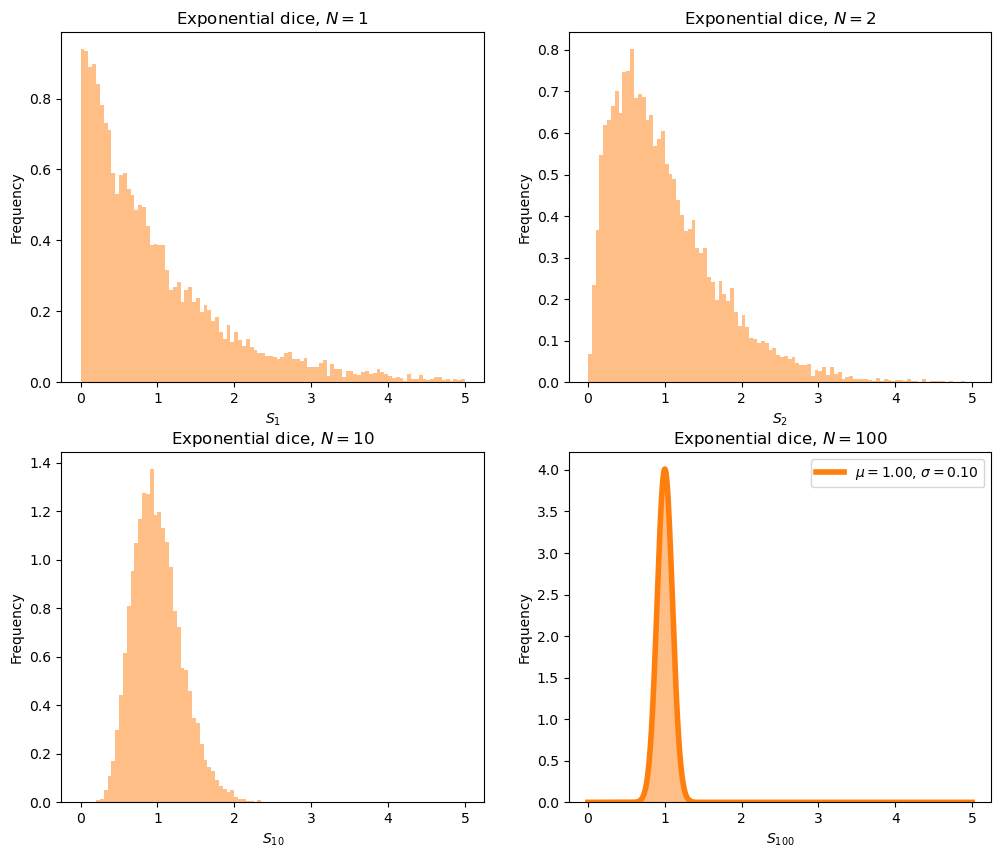

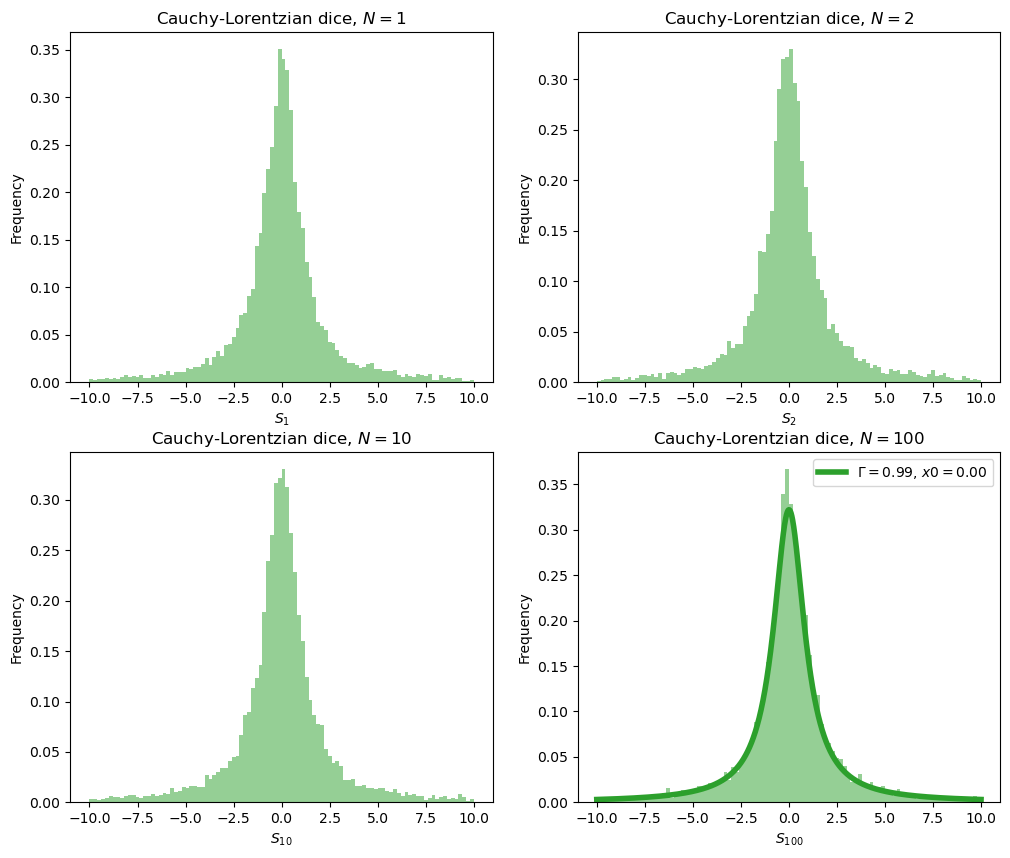

In [43]:
sumsize = [1, 2, 10, 100]    
name = [
    "Uniform dice",
    "Exponential dice",
    "Cauchy-Lorentzian dice"
]

unif_s1, expo_s1, cauchy_s1         = np.loadtxt("../data/ex01_2s_1.dat", unpack=True, usecols=(0,1,2))
unif_s2, expo_s2, cauchy_s2         = np.loadtxt("../data/ex01_2s_2.dat", unpack=True, usecols=(0,1,2))
unif_s10, expo_s10, cauchy_s10      = np.loadtxt("../data/ex01_2s_10.dat", unpack=True, usecols=(0,1,2))
unif_s100, expo_s100, cauchy_s100   = np.loadtxt("../data/ex01_2s_100.dat", unpack=True, usecols=(0,1,2))

unif = [unif_s1, unif_s2, unif_s10, unif_s100]

data = [
    [unif_s1, unif_s2, unif_s10, unif_s100],
    [expo_s1, expo_s2, expo_s10, expo_s100],
    [cauchy_s1, cauchy_s2, cauchy_s10, cauchy_s100]
]

limits = [
    (0,1),
    (0,5),
    (-10,10)
]

def gauss(x, mu, sigma):
    return norm.pdf(x, mu, sigma)

def cauchylorentz(x, gamma, x0):
    return cauchy.pdf(x, x0, gamma)

def fit_gauss(data, dist):
    mu, sigma = norm.fit(data)
    x = np.linspace(limits[dist][0], limits[dist][1], 1000)
    y = gauss(x, mu, sigma)
    return x, y, mu, sigma

def fit_cauchy(data, dist):
    x0, gamma = cauchy.fit(data)
    # popt, pcov = curve_fit(cauchy, data)
    x = np.linspace(limits[dist][0], limits[dist][1], 1000)
    y = cauchylorentz(x, gamma, x0)
    return x, y, x0, gamma


n_bins = 100

for dist in range(3):
    plt.figure(figsize = (12,10))
    for sum in range(4):
        plt.subplot(2,2,sum+1)
        m = plt.hist(data[dist][sum], n_bins, range=limits[dist], density=True, color=colors[dist], alpha=0.50)
        if sum == 3:
            if dist != 2:
                x, y, mu, sigma = fit_gauss(data[dist][sum], dist)
                title = r"$\mu={mu:.2f}$, $\sigma={sigma:.2f}$".format(mu=mu, sigma=sigma)
                plt.plot(x, y, label=title, linewidth=4, color=colors[dist])
                plt.legend()
            if dist == 2:
                x, y, x0, gamma = fit_cauchy(cauchy_s100, dist)
                title = r"$\Gamma={gamma:.2f}$, $x0={x0:.2f}$".format(gamma=gamma, x0=x0)
                plt.plot(x, y, label=title, linewidth=4, color=colors[dist])
                plt.legend()
        plt.title(r"{name}, $N={size}$".format(name=name[dist], size=sumsize[sum]))
        plt.xlabel(r"$S_{%d}$" % sumsize[sum])
        plt.ylabel("Frequency")
    plt.show()




## Exercise 01.3

#### Assignment
- **Simulate** the Buffon’s experiment (see LSN_Lecture_00, supplementary material):  A needle of length $L$ is thrown at random onto a horizontal plane ruled with straight lines a distance $d$ (must be $d > L$, but do not use $d\gg L$ otherwise $P\ll 1$) apart. The probability $P$ that the needle will intersect one of these lines is: $P = 2L/\pi d$. This could be used to evaluate $\pi$ from throws of the needle: if the needle is thrown down $N_{thr}$ times and is observed to land on a line $N_{hit}$ of those times, we can make an estimate of $\pi$ from
$$\pi = \frac{2L}{Pd} = \lim_{N_{thr} \to \infty}\frac{2LN_{thr}}{N_{hit}d}$$
Make a picture of the estimation of $\pi$ and its uncertainty (Standard Deviation of the mean) with a large number of *throws* $M$ as a function of the number of blocks, $N$ (see below: Computing statistical uncertainties). If possible, do not use $\pi$ to evaluate $\pi$.

### Resolution
The throw of a needle can be reduced to 2 variables being sampled:
- $x$, position of the center of the needle
- $\theta$, angle of the needle with respect to the lines

To reduce complexity we can leverage the symmetries in the system: I've chosen to sample $x$ with an uniform distribution in the interval $[0, d/2]$, and $\theta$ with an uniform distribution in the interval $[0, \pi / 2]$.
However, per the request of the exercise, we cannot sample the angle in this way.
We instead check if the needle passes a line by checking if the distance from the center of the needle to the closest line is less than $\frac{L}{2}  \sin(\theta)$.
So $x$ is sampled in the interval $[0, d/2]$, but by checking in this way the /2 is not needed. Therefore the expression to evaluate to check if the needle passes a line is:
$$
x < L \cdot \sin(\theta) 
$$
where $x$ will be uniformly sampled in the interval $[0, d]$.

We still need a way to sample $\sin(\theta)$. We extract a couple of random numbers $r_x$ and $r_y$ from the uniform distribution in the interval $[0,1]$, as long they lives inside the unit circle. This way the couples will be distributed inside thi first quadrant of the unit circle, which corrispond to $\theta \in [0, \pi/2]$. 
Then we can compute the sine as:
$$
\sin(\theta) = \frac{\sqrt{r_x^2 + r_y^2}}{r_x}
$$

The expression used in the code is further simplified as:
$$
r \cdot \sin(\theta) \le \frac{L}{d}
$$
where $r$ is sampled in the interval $[0, 1]$, and $\sin(\theta)$ as previously shown.

#### Code
The code is derived from the [Exercise01.1](#code) class. The methods ```Funny``` and ```Average``` are overridden in the derived class ```Buffon``` following the logic described above:
```cpp
void BlockingBuffon::Average(Random &rnd){
    for(size_t i{0}; i<l_block; i++){
        Funny(rnd);
    }
    // calculate pi = 2*l/(d*P) where P is how many needles have passed a line
    double curr_pi = ((double)l_block/sum)*(2.*(l/d));
    cum_avg += curr_pi;
    cum_avg2 += curr_pi*curr_pi;
}

// in this case funny is the needle throw
// the needle is thrown and one is added when the needle crosses a line
void BlockingBuffon::Funny(Random &rnd){
    double x{rnd.Rannyu()}, y{rnd.Rannyu()};
    // regenerate x,y until x and y are inside the unit circle
    while(x*x+y*y>1){
        x = rnd.Rannyu();
        y = rnd.Rannyu();
    }
    // check if needle passes the line
    if((rnd.Rannyu() * sqrt(x*x+y*y))/ x /* sin function! */ <=(l/d)){
        sum += 1.;
    }
    //sum += ((double)rnd.Rannyu()/(acos(1.-(double)rnd.Rannyu()))>(l/d))?0.:1.;
}
```

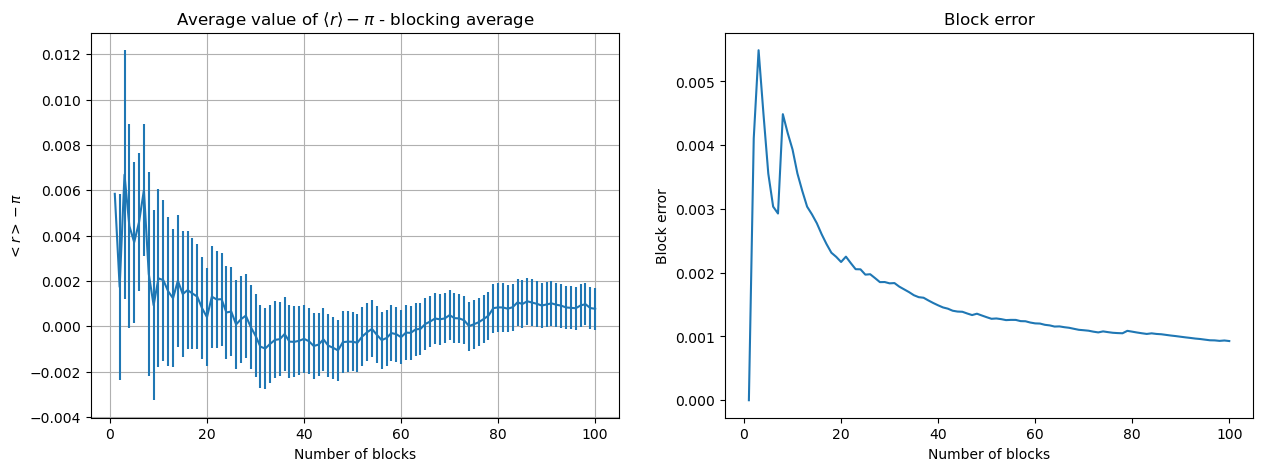

In [37]:

n_throws, cum_avg, block_error = np.loadtxt("../data/ex01_3.dat", unpack=True, usecols=(0,1,2))

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.errorbar(n_throws, cum_avg-np.pi, yerr=block_error)
plt.title(r"Average value of $\langle r \rangle - \pi$ - blocking average")
plt.xlabel('Number of blocks')
plt.ylabel(r"$<r> - \pi$")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(n_throws, block_error)
plt.title("Block error")
plt.xlabel('Number of blocks')
plt.ylabel('Block error')

plt.show()



## Notes on code philosophy
The ```Random``` class provided from the NSL ariel site has receivede a new method to initialize the generator.

For the first exercises the blocking average logic has been implemented in the ```BlockingAvg``` class, included in [```library01.h```](../exercise_01/library01.h). The design philosopy is to have a base class from which to inherit to implement the specific exercise, such as the ```BlockingVar``` class, or the ```BlockingBuffon``` class. By leverage polymorphism we can have a single main function that can run the different exercises. However, later on this choise will be more of a burden than a help.